<a href="https://www.kaggle.com/code/keremkosif/disaster-prediction-using-nlp?scriptVersionId=118314857" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Disaster Prediction with Lemmatization and Preprocessing
In this notebook, I tried to build a model for a disaster dataset. I also used Lemmatization and Preprocessing to clean the data. This dataset includes tweets that contain information about some disasters. However, not all words are used for disaster meaning some may be used figuratively. So in This notebook, I will first preprocess the tweets, remove punctuations and stop words, transform words into paddings and finally build an LSTM model for detecting if tweets were related to a disaster.

## Import Libraries

In [1]:
from tensorflow import keras
from nltk.corpus import stopwords
import os
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
from tqdm import tqdm
from wordcloud import WordCloud

tf.get_logger().setLevel('ERROR')

## Importing Datasets
In this notebook my goal is prioritizing lemmatization and regular expression for preprocessing. So I will only use index and text columns of the dataset. Also null values must be 

In [2]:
df = pd.read_csv('../input/nlp-getting-started/train.csv')

## Starting the Preprocessing!
## Step 1 Stop Words

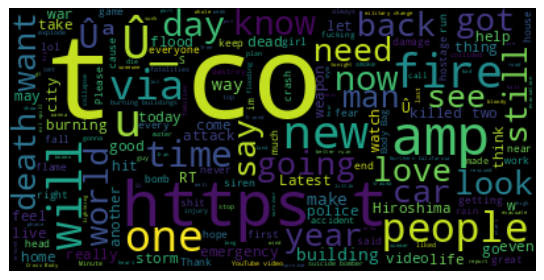

In [3]:
text = "".join(df["text"].to_list())
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(8, 6), dpi=85)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [4]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Step2 Regular Expression

In [5]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
cl_df = df.copy()
cl_df = cl_df.drop(["keyword", "location", "id"], axis=1)

In [7]:
cl_df["text"] = [re.sub("[^a-zA-Z]", " ", line) for line in cl_df["text"]]

In [8]:
cl_df["text"] = [line.lower() for line in cl_df["text"]]

In [9]:
cachedStopWords = stopwords.words("english")
stopped_list = []
for line in cl_df["text"]:
    text = ' '.join([word for word in line.split() if word not in cachedStopWords])
    stopped_list.append(text)
cl_df["text"] = stopped_list

In [10]:
lemmatizer = spacy.load('en_core_web_sm')
lemmatized_list = []
for line in cl_df["text"]:
    word = " ".join([token.lemma_ for token in lemmatizer(line)])
    lemmatized_list.append(word)
cl_df["text"] = lemmatized_list

## Reading the Processed Datasets

In [11]:
X = cl_df["text"]
y = cl_df["target"]

## Splitting the Dataset

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Embedding HyperParameters

In [13]:
vocab_size = 10000
embedding_dim = 64
max_length = 25
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

## Tokenization and Padding

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Model Creation

In [16]:
from keras import layers

emb_model = keras.models.Sequential()
emb_model.add(layers.Embedding(vocab_size, 32, input_length=max_length))
emb_model.add(layers.Bidirectional(layers.LSTM(32)))#, recurrent_dropout=0.2)))
emb_model.add(layers.Dropout(0.25))
emb_model.add(layers.BatchNormalization())

emb_model.add(layers.Dense(64, activation='relu'))
emb_model.add(layers.Dropout(0.25))
emb_model.add(layers.BatchNormalization())

emb_model.add(layers.Dense(32, activation='relu'))
emb_model.add(layers.Dropout(0.25))
emb_model.add(layers.BatchNormalization())

emb_model.add(layers.Dense(1, activation='sigmoid'))

2023-02-05 22:16:44.421195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 22:16:44.422460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 22:16:44.423218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 22:16:44.424101: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
optimizer = keras.optimizers.Adam(0.00003)
emb_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', restore_best_weights=True)
history = emb_model.fit(X_train_pad, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid_pad, y_valid), callbacks=[earlyStopping])

2023-02-05 22:16:53.662447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-02-05 22:16:57.533052: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


179/179 [==============================] - 8s 15ms/step - loss: 0.8944 - accuracy: 0.4962 - val_loss: 0.6868 - val_accuracy: 0.5814
Epoch 2/50
179/179 [==============================] - 2s 11ms/step - loss: 0.8571 - accuracy: 0.5092 - val_loss: 0.7026 - val_accuracy: 0.4480
Epoch 3/50
179/179 [==============================] - 2s 9ms/step - loss: 0.8295 - accuracy: 0.5295 - val_loss: 0.6793 - val_accuracy: 0.5572
Epoch 4/50
179/179 [==============================] - 2s 9ms/step - loss: 0.7997 - accuracy: 0.5518 - val_loss: 0.6395 - val_accuracy: 0.6387
Epoch 5/50
179/179 [==============================] - 2s 10ms/step - loss: 0.7631 - accuracy: 0.5673 - val_loss: 0.6242 - val_accuracy: 0.6555
Epoch 6/50
179/179 [==============================] - 2s 9ms/step - loss: 0.7643 - accuracy: 0.5652 - val_loss: 0.6181 - val_accuracy: 0.6586
Epoch 7/50
179/179 [==============================] - 2s 9ms/step - loss: 0.7397 - accuracy: 0.5829 - val_loss: 0.6030 - val_accuracy: 0.6807
Epoch 8/50
179

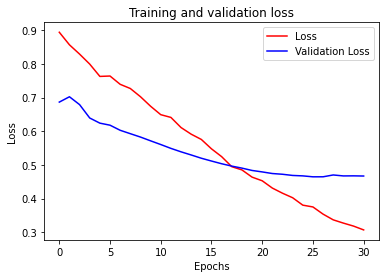

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(len(history.history["loss"]))]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

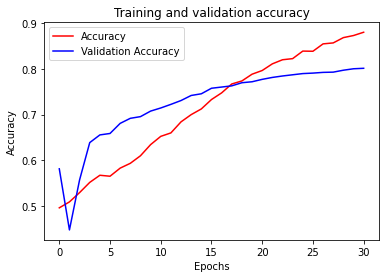

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

## Submission

In [21]:
def process_test_data(df_input):
    # Pre-processing
    df_input = df_input.drop(["keyword", "location", "id"], axis=1)
    df_input["text"] = [re.sub("[^a-zA-Z]", " ", line) for line in df_input["text"]]
    df_input["text"] = [line.lower() for line in df_input["text"]]
    
    # Stop Words
    cachedStopWords = stopwords.words("english")
    stopped_list = []
    for line in df_input["text"]:
        text = ' '.join([word for word in line.split() if word not in cachedStopWords])
        stopped_list.append(text)
    df_input["text"] = stopped_list

    # Lemmatization
    lemmatizer = spacy.load('en_core_web_sm')
    lemmatized_list = []
    for line in df_input["text"]:
        word = " ".join([token.lemma_ for token in lemmatizer(line)])
        lemmatized_list.append(word)
    df_input["text"] = lemmatized_list
    return df_input

In [22]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

df_processed = process_test_data(df_test)
X_sub = df_processed["text"]
df_test.set_index('id',inplace=True)

In [23]:
tokenizer.fit_on_texts(X_sub)
X_sub_seq = tokenizer.texts_to_sequences(X_sub)
X_sub_pad = pad_sequences(X_sub_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [24]:
y_pred = emb_model.predict(X_sub_pad)
y_pred = y_pred.round(0).astype(int).reshape(-1)
submission=pd.DataFrame({'target':y_pred},index=X_sub.index)

In [25]:
submission.to_csv('../working/submission.csv')